In [1]:
import copy
import gym
import itertools
import matplotlib
import numpy as np
import sys

from collections import defaultdict, namedtuple
from functools import partial
from matplotlib import pyplot as plt
from tqdm import tqdm

from lib.envs.gridworld import GridworldEnv

plt.style.use('ggplot')

## Utility functions and classes

In [12]:
EpisodeStats = namedtuple(
    "EpisodeStats", ["episode_lengths", "episode_rewards", "max_action_value"])

class DynamicEpsilonGreedyPolicy(object):
    def __init__(self, Q, num_actions):
        self.Q = Q
        self.num_actions = num_actions
        self.reset()
        
    def reset(self):
        self.num_seen = defaultdict(lambda: 0)

    def __call__(self, observation):
        self.num_seen[observation] += 1
        epsilon = 1.0 / np.sqrt(self.num_seen[observation])
        return epsilon_greedy_policy(observation,
                                     Q=self.Q,
                                     epsilon=epsilon,
                                     num_actions=self.num_actions)
    
class ConstantLearningRate(object):
    def __init__(self, alpha):
        self.alpha = alpha
        
    def __call__(self, observation, action):
        return self.alpha
    
class PolynomialLearningRate(object):
    def __init__(self, alpha=1.0, power=0.8):
        self.alpha = alpha
        self.power = power
        self.reset()
        
    def reset(self):
        self.num_updates = defaultdict(lambda: 0)
        
    def __call__(self, observation, action):
        self.num_updates[(observation, action)] += 1
        alpha = self.alpha / pow(self.num_updates[(observation, action)], self.power)
        return alpha

def epsilon_greedy_policy(observation, Q, epsilon, num_actions):
    A = np.ones(num_actions, dtype=np.float) * epsilon / num_actions
    best_action = np.argmax(Q[observation])
    A[best_action] += (1.0 - epsilon)
    return A

def simulate_greedy_policy(env, Q):
    policy = partial(epsilon_greedy_policy,
                     Q=Q,
                     epsilon=0.0,
                     num_actions=env.action_space.n)
            
    state = env.reset()
  
    for t in itertools.count():
        action_probs = policy(state)
        action = np.random.choice(env.action_space.n, p=action_probs)
        state, reward, done, _ = env.step(action)

        env.render()
        print ""
        if done:
            break

## Learning algorithms

### Vanilla Q Learning

In [3]:
def q_learning(env, num_episodes, discount_factor=0.95, alpha=ConstantLearningRate(0.5)):
    """
    Q-Learning algorithm. An off-policy TD control. Finds an estimate of the optimal greedy policy
    using an epsilon-greedy behavior policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run.
        discount_factor: The discount factor for the rewards.
        alpha: TD learning rate rule.
        
    Returns:
        A tuple (Q, stats).
        Q: The optimal action-value estimate according to the algorithm (a dictionary mapping
        state -> action values). 
        stats: Useful statistics of the training procedure.
    """
    
    # We start with an all-zero Q-function estimate.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keep track of useful statistics.
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        max_action_value=np.zeros(num_episodes))
    
    # Define epsilon-greedy w.r.t. the combined estimates.
    # NOTE: We don't need to redefine it every time as it deals with pointers to objects
    #       thus is always up to date.
    policy = DynamicEpsilonGreedyPolicy(Q=Q, num_actions=env.action_space.n)
    
    # Run episodes.
    for episode_idx in xrange(num_episodes):  
        state = env.reset()
  
        for t in itertools.count():
            # Act according to the behavior policy.
            action_probs = policy(state)
            action = np.random.choice(env.action_space.n, p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Now we need to update the estimates.
            # Note, that we use argmax here instead of simply taking max to be consistent
            # with the Double Q-Learning algorithm that is implemented below.
            best_action = np.argmax(Q[next_state])
            Q[state][action] += alpha(state, action) * (reward +
                                                        discount_factor * Q[next_state][best_action] - 
                                                        Q[state][action])
            
            # Update reward statistics.
            stats.episode_rewards[episode_idx] += reward
            
            # Transition into the next state.
            state = next_state
            if done:
                stats.episode_lengths[episode_idx] = t
                stats.max_action_value[episode_idx] = np.max(Q[6])
                break
               
    return Q, stats

### Double Q-Learning

In [4]:
def double_q_learning(env, num_episodes, discount_factor=0.95, alpha=ConstantLearningRate(0.5)):
    """
    Double Q-Learning algorithm from the paper "Double Q-learning" by van Hasselt (2011). Addresses the
    problem of overestimation of the action values due to usage of the maximum action value as an
    approximation for the maximum expected action value. The solution is to maintain two independent 
    estimates which are used to update each other.
    
    Args:
        env: OpenAI environment.
        num_epsisodes: Number of episodes to run.
        discount_factor: The discount factor for the rewards.
        alpha: TD learning rate rule.
        
    Returns:
        A triplet (Q1, Q2, stats).
        Q1, Q2: The optimal action-value estimates according to the algorithm (a dictionary mapping
        state -> action values). 
        stats: Useful statistics of the training procedure.
    """
    
    # Setup learning rates.
    alpha1 = alpha
    alpha2 = copy.deepcopy(alpha)
    
    # We start with an all-zero Q-function estimates.
    Q1 = defaultdict(lambda: np.zeros(env.action_space.n))
    Q2 = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Define a combination of Q-function estimates for the behavior policy.
    class CombinedQ(object):
        def __getitem__(self, observation):
            return 0.5 * (Q1[observation] + Q2[observation])
    combined_Q = CombinedQ()
    
    # Keep track of useful statistics.
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        max_action_value=np.zeros(num_episodes))
    
    # Define epsilon-greedy w.r.t. the combined estimates.
    # NOTE: We don't need to redefine it every time as it deals with pointers to objects
    #       thus is always up to date.
    policy = DynamicEpsilonGreedyPolicy(Q=combined_Q, num_actions=env.action_space.n)
    
    # Run episodes.
    for episode_idx in xrange(num_episodes):            
        state = env.reset()
  
        for t in itertools.count():
            # Act according to the behavior policy.
            action_probs = policy(state)
            action = np.random.choice(env.action_space.n, p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Now we need to update the estimates. We take one of them at random with
            # equal probability.
            target_Q, source_Q, alpha = (Q1, Q2, alpha1) if np.random.random() < 0.5 else (Q2, Q1, alpha2)
            best_action = np.argmax(target_Q[next_state])
            target_Q[state][action] += alpha(state, action) * (reward +
                                                               discount_factor * source_Q[next_state][best_action] - 
                                                               target_Q[state][action])
            
            # Update reward statistics.
            stats.episode_rewards[episode_idx] += reward
            
            # Transition into the next state.
            state = next_state
            if done:
                stats.episode_lengths[episode_idx] = t
                stats.max_action_value[episode_idx] = np.max(combined_Q[6])
                break
        
    return Q1, Q2, stats

## Grid world experiment from the original paper

For the full description of the experiment please refer to the **section 4.2** in the original Double Q-Learning paper (van Hasselt, 2011).

### Run training

In [5]:
env = GridworldEnv()

In [6]:
num_trials = 1000

In [7]:
from joblib import Parallel, delayed

In [8]:
def job(seed):
    np.random.seed(seed=None)
    _, stats = q_learning(env, 300, alpha=PolynomialLearningRate())
    return stats

all_stats = Parallel(n_jobs=8)([delayed(job)(s) for s in np.random.randint(0, num_trials * 1000, num_trials)])

q_learning_stats = EpisodeStats(
    episode_lengths=sum([s.episode_lengths for s in all_stats]) / num_trials,
    episode_rewards=sum([s.episode_rewards for s in all_stats]) / num_trials,
    max_action_value=sum([s.max_action_value for s in all_stats]) / num_trials)

In [9]:
def job(seed):
    np.random.seed(seed=None)
    _, _, stats = double_q_learning(env, 4000, alpha=PolynomialLearningRate())
    return stats

all_stats = Parallel(n_jobs=8)([delayed(job)(s) for s in np.random.randint(0, num_trials * 1000, num_trials)])

double_q_learning_stats = EpisodeStats(
    episode_lengths=sum([s.episode_lengths for s in all_stats]) / num_trials,
    episode_rewards=sum([s.episode_rewards for s in all_stats]) / num_trials,
    max_action_value=sum([s.max_action_value for s in all_stats]) / num_trials)

### Show nice plots

In [10]:
def plot_paper_results(q_learning_stats, double_q_learning_stats):
    # Plot maximal Q over time.
    fig = plt.figure(figsize=(10, 8))
    
    plt.plot(np.cumsum(q_learning_stats.episode_lengths), q_learning_stats.max_action_value,
             'r', label='Q-Learning')
    plt.plot(np.cumsum(double_q_learning_stats.episode_lengths), double_q_learning_stats.max_action_value, 
             'b', label='Double Q-Learning')
    plt.plot([0, 10000], [0.36, 0.36], 'k:')
    
    plt.xlim(0, 10000)
    
    plt.xlabel("Time Steps")
    plt.ylabel("$ max_a Q(S, a) $")
    plt.title("Maximal Action-Value over Time")
    plt.legend()
    
    plt.show(fig)
    
    # Plot rewards per step.
    fig = plt.figure(figsize=(10, 8))
    
    rewards_per_step = q_learning_stats.episode_rewards / q_learning_stats.episode_lengths
    plt.plot(np.cumsum(q_learning_stats.episode_lengths), rewards_per_step,
             'r', label='Q-Learning')
    rewards_per_step = double_q_learning_stats.episode_rewards / double_q_learning_stats.episode_lengths
    plt.plot(np.cumsum(double_q_learning_stats.episode_lengths), rewards_per_step, 
             'b', label='Double Q-Learning')
    plt.plot([0, 10000], [0.2, 0.2], 'k:')
    
    plt.xlim(0, 10000)
    
    plt.xlabel("Time Steps")
    plt.ylabel("$ r $ per Step")
    plt.title("Average Rewards per Step over Time")
    plt.legend()
    
    plt.show(fig)

Here we would like to verify that vanilla Q-Learning overestimates the action-value function whereas Double Q-Learning underestimates.

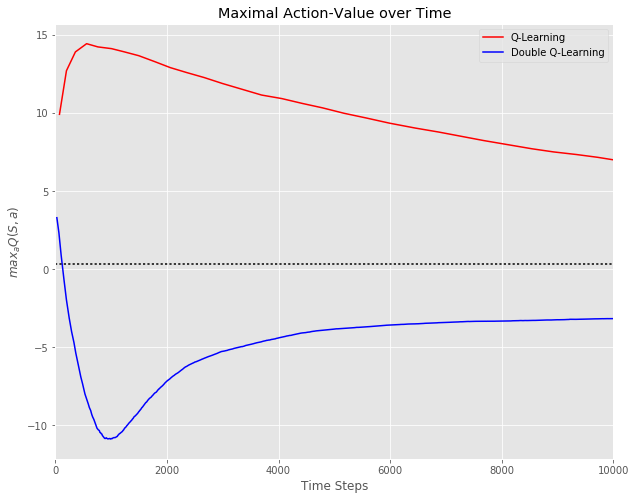

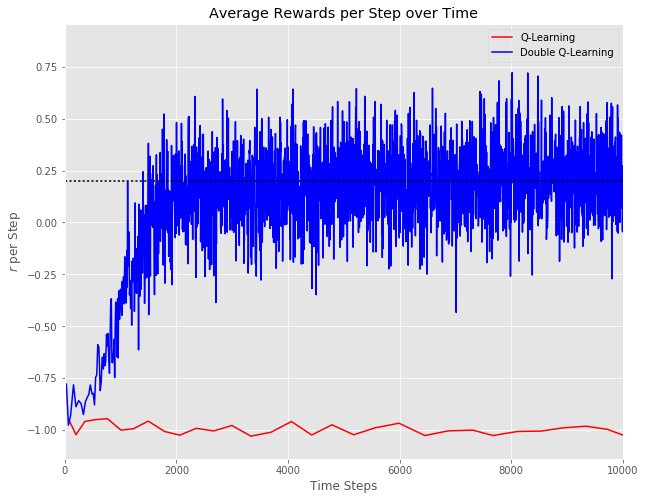

In [11]:
plot_paper_results(q_learning_stats, double_q_learning_stats)

Indeed, this is what happens in this toy experiment (see the *first* plot). Although the error of the action values is comparable, the policies found by Double Q-Learning are better (see the *second* plot).